# Modeling and Simulation in Python

Chapter 11: Rotation

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

In [3]:
condition = Condition(Rmin = 0.02 * m,
                      Rmax = 0.055 * m,
                      L = 47 * m,
                      duration = 130 * s)

In [4]:
def estimate_k(condition):
    unpack(condition)
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

In [5]:
def make_system(condition):
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = Rmin)
    
    k = estimate_k(condition)
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, ts=ts)

In [6]:
system = make_system(condition)
system

,value
init,theta 0 radian y 0 meter r ...
k,2.7925531914893616e-05 meter
ts,"[0.0 second, 1.3 second, 2.6 second, 3.9000000..."


In [7]:
system.init

,value
theta,0 radian
y,0 meter
r,0.02 meter


In [8]:
def slope_func(state, t, system):
    theta, y, r = state
    unpack(system)
    
    omega = 10 * radian / s
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

In [9]:
slope_func(system.init, 0*s, system)

(<Quantity(10.0, 'radian / second')>,
 <Quantity(0.2, 'meter * radian / second')>,
 <Quantity(0.0002792553191489362, 'meter * radian / second')>)

In [10]:
run_odeint(system, slope_func)

In [11]:
system.results.tail()

,theta,y,r
124.8,1248.0,46.707064,0.054851
126.1,1261.0,47.422487,0.055214
127.4,1274.0,48.142630,0.055577
128.7,1287.0,48.867493,0.055940
130.0,1300.0,49.597074,0.056303


In [12]:
thetas = system.results.theta
ys = system.results.y
rs = system.results.r * 1000

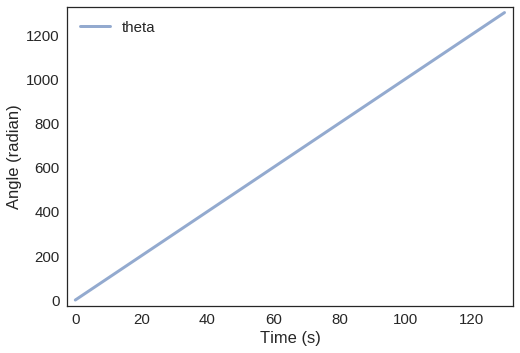

In [13]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (radian)')

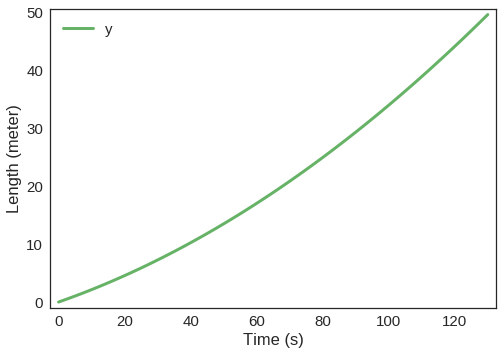

In [14]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (meter)')

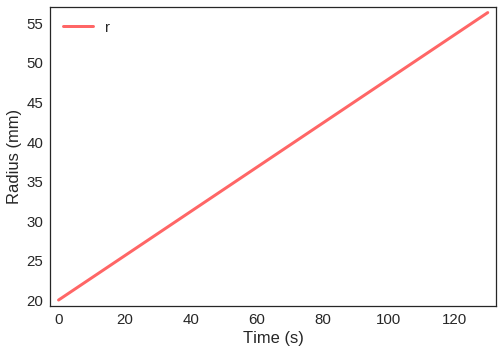

In [15]:
plot(rs, color='red', label='r')

decorate(xlabel='Time (s)',
         ylabel='Radius (mm)')

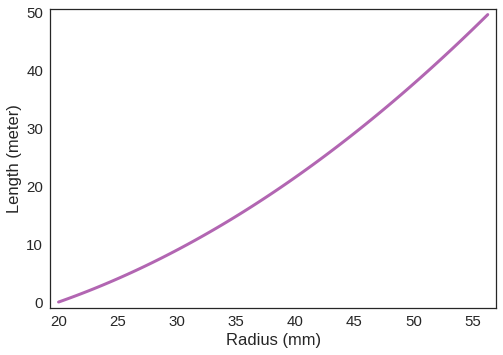

In [17]:
plot(rs, ys, color='purple')

decorate(xlabel='Radius (mm)',
         ylabel='Length (meter)',
         legend=False)

Saving figure to file chap11-fig01.pdf


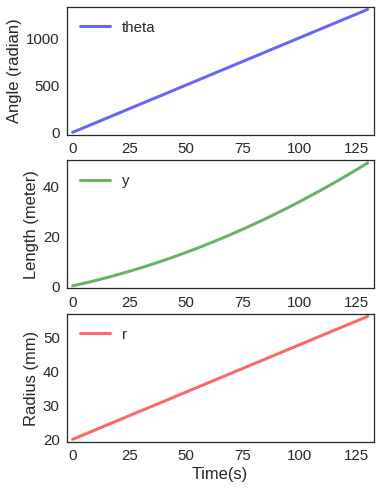

In [19]:
subplot(3, 1, 1)
plot(thetas, color='blue', label='theta')
decorate(ylabel='Angle (radian)')

subplot(3, 1, 2)
plot(ys, color='green', label='y')
decorate(ylabel='Length (meter)')

subplot(3, 1, 3)
plot(rs, color='red', label='r')

decorate(xlabel='Time(s)',
         ylabel='Radius (mm)')

savefig('chap11-fig01.pdf')

In [20]:
T = interp_inverse(ys, kind='cubic')
t_end = T(47)
t_end

array(125.33333334940457)

In [21]:
R = interpolate(rs, kind='cubic')
R(t_end)

array(55.00000000448797)

In [22]:
THETA = interpolate(thetas, kind='cubic')
THETA(t_end)

array(1253.3333334940455)

### Unwinding

In [67]:
kg = UNITS.kilogram
N = UNITS.newton

In [68]:
condition = Condition(Rmin = 0.02 * m,
                      Rmax = 0.055 * m,
                      Mcore = 15e-3 * kg,
                      Mroll = 215e-3 * kg,
                      L = 47 * m,
                      tension = 2e-4 * N,
                      duration = 180 * s)

In [95]:
def make_system(condition):
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L)
    
    area = pi * (Rmax**2 - Rmin**2)
    rho = Mroll / area
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, rho=rho,
                  Rmin=Rmin, Rmax=Rmax,
                  Mcore=Mcore, Mroll=Mroll, 
                  ts=ts)

In [96]:
system = make_system(condition)
system

,value
init,theta 0 radian omega 0.0 radi...
k,2.7925531914893616e-05 meter / radian
rho,26.07109543981524 kilogram / meter ** 2
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
ts,"[0.0 second, 1.8 second, 3.6 second, 5.4 secon..."


In [97]:
system.init

,value
theta,0 radian
omega,0.0 radian / second
y,47 meter


In [98]:
def moment_of_inertia(r, system):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    system: System object with Mcore, rho, Rmin, Rmax
    
    returns: moment of inertia in kg m**2
    """
    unpack(system)
    Icore = Mcore * Rmin**2   
    if r < Rmin:
        Iroll = 0
    else:
        Iroll = pi * rho / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

In [99]:
moment_of_inertia(system.Rmin, system)

<Quantity(6e-06, 'kilogram * meter ** 2')>

In [100]:
moment_of_inertia(system.Rmax, system)

<Quantity(0.00037418750000000006, 'kilogram * meter ** 2')>

In [101]:
def slope_func(state, t, system):
    theta, omega, y = state
    unpack(system)
    
    r = sqrt(2*k*y + Rmin**2)
    if r < Rmin:
        return 0, 0, 0, 0
        
    I = moment_of_inertia(r, system)
    tau = r * tension
    alpha = tau / I
    dydt = -r * omega
    
    return omega, alpha, dydt      

In [102]:
slope_func(system.init, 0*s, system)

(<Quantity(0.0, 'radian / second')>,
 <Quantity(0.02939702689159846, 'newton / kilogram / meter / radian ** 0.5')>,
 <Quantity(-0.0, 'meter * radian ** 0.5 / second')>)

In [103]:
run_odeint(system, slope_func)

In [104]:
system.results.tail()

,theta,omega,y
172.8,503.376998,6.830222,22.852269
174.6,515.788219,6.960580,22.346268
176.4,528.437150,7.094376,21.835001
178.2,541.330151,7.231802,21.318468
180.0,554.473940,7.373066,20.796665


In [105]:
thetas = system.results.theta
ys = system.results.y

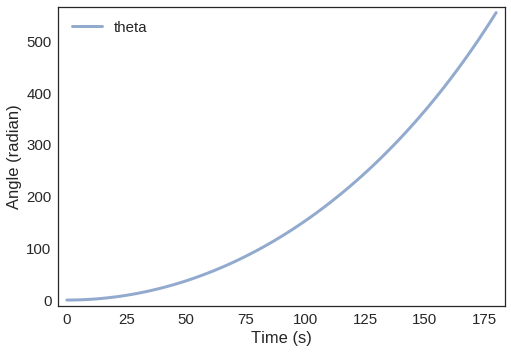

In [106]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (radian)')

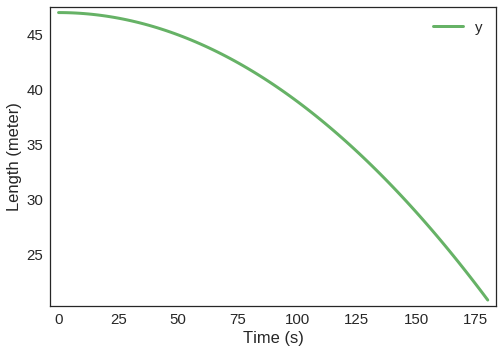

In [107]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (meter)')

### Yo-yo

In [ ]:
condition = Condition(Rmin = 8e-3 * m,
                      Rmax = 16e-3 * m,
                      Rout = 35e-3 * m,
                      mass = 50e-3 * kg,
                      L = 0.9 * m,
                      g = 9.8 * m / s**2,
                      duration = 1 * s)

In [ ]:
def make_system(condition):
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = 0 * m,
                 v = 0 * m / s,
                 r = Rmax)
    
    I = mass * Rout**2 / 2
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, rho=rho,
                  Rmin=Rmin, Rmax=Rmax,
                  mass=mass, I=I, g=g,
                  ts=ts)

In [ ]:
system = make_system(condition)
system

In [ ]:
system.init

In [ ]:
def slope_func(state, t, system):
    theta, omega, y, v, r = state
    unpack(system)
    
    if r < Rmin:
        return 0, 0, 0, 0, 0
        
    a = g * mass * r**2 / (I + mass * r**2)
    alpha = a / r
    dydt = r * omega
    drdt = -k * omega
    
    print(a/g)
    
    return omega, alpha, dydt, a, drdt        

In [ ]:
slope_func(system.init, 0*s, system)

In [ ]:
run_odeint(system, slope_func)

In [ ]:
system.results.tail()

In [ ]:
thetas = system.results.theta
ys = system.results.y
rs = system.results.r * 1000

In [ ]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (radian)')

In [ ]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (meter)')

In [ ]:
plot(rs, color='red', label='r')

decorate(xlabel='Time (s)',
         ylabel='Radius (mm)')

In [ ]:
plot(rs, ys, color='purple')

decorate(xlabel='Radius (mm)',
         ylabel='Length (meter)',
         legend=False)

In [ ]:
def plot_acceleration(system):
    unpack(system)

    rs = linspace(Rmin, Rmax)
    a = g * mass * rs**2 / (I + mass * rs**2)
    plot(rs, a)

In [ ]:
plot_acceleration(system)